## Uncertainty Quantification - Monte Carlo Simulation

---

This notebook will quantify log k values for various species using a Monte Carlo method with lower and upper bounds from literature. See below:

Mahoney et al. (2009). Uranyl Adsorption on to Hydrous Ferric Oxcide--A Re-Evaluation for the Diffuse Layer Model Database. *Environmental Science and Technology,* *43*(24), 9263. doi: 10.1021/es901586w

#### Set up initial parameters and uncertainty bounds

*pqcpath*: path to phreeqc.bat executable

*TDBfile*: name of phreeqc database file without file extension

*outfile*: name of phreeqc output file including file extension

*infile*: name of phreeqc input file including file extension

In [3]:
import os 
import numpy.random
from writeIOphreeqc import*
import matplotlib.pyplot as plt

# these are used when we run phreeqc in run_sims()
pqcpath = 'C:/Users/htzen/Desktop/phreeqc-3.7.0-15749-x64/bin/phreeqc'
TDBfile = 'llnl_Mahoney_updated'
outfile = 'Outputfile3.out'
infile = 'U_HFO_input3.txt'

# bounds from table 2 in Mahoney et. al.
pars    = ['!Hfo_sOUO2+!', '!Hfo_wOUO2+!', '!Hfo_wOUO2CO3-!', '!Hfo_wOUO2(CO3)2-3!']
lower = [1.62, 1.79, 8.75, 15.1]
upper = [5.85, 3.28, 9.32, 15.28]

# setting up values from experimental results for later plotting
exp_pH = [3.56041,4.07969,4.51985,5.00029,5.47929,5.93959]
exp_U = [0.099831,0.071537,0.029899,0.001774,0,0]


# extraneous verify function which can be a simple sanity check for longer lists
def verify(low, upp):
    """
    checks length and bounds of lists for correct format
    """
    if len(low) == len(upp):
        
        if all([low[i] <= upp[i] for i in range(len(low))]):
            print("verify: bounds check out")
            return True
        print("verify: error -- listed bounds are inconsistent")
        return False
    
    print("verify: error -- lists are different lenghts")
    return False



# searches for the '-find ' key in the input file to get the name of the .sel output file
# (assumes .sel file is in the current directory)
def find_opsel(infile):
    
    with open(infile, 'r') as f:
        for line in f.readlines():
            if line.find("-file ") > 0:
                return line[line.find("-file ")+len("-file "):-1]
            
    print("error: unable to find output file in {}".format(infile))
    return -1

# verify bounds and set phreeqc output to read
verify(lower, upper)
opsel = find_opsel(infile)
#print(opsel)

verify: bounds check out


#### Define methods for Monte Carlo simulation

In a Monte Carlo simulation we will generate random values for the parameters within the upper/lower bounds for each run

In [4]:
# returns a matrix of random values between lower and upper
def get_random_values(lower, upper, num_iter):
    # lower, upper: lists of bounds to generate within
    # num_iter: number of sets to generate
    # return: num_iter by len(lower) matrix
    
    # generate 1st row
    matrix = np.zeros(len(lower))
    for i in range(len(lower)):
        matrix[i] = numpy.random.uniform(lower[i], upper[i])
        
    # generate more rows if needed
    if num_iter < 2:
        return [matrix]
    else:
        for j in range(num_iter-1):
            values = np.zeros(len(lower))
            for i in range(len(lower)):
                values[i] = numpy.random.uniform(lower[i], upper[i])
            matrix = np.vstack((matrix, values))
        return matrix

# runs a phreeqc simulation for each row of parameters in values_mtrx
# requires various path variables to be set correctly at beginning of file
def run_sims(values_mtrx, opsel, analytes=['pH', 'U']):
    # values_mtrx: matrix of values generated from get_random_values or similar function
    # analytes: list of element keywords to search for in .out file generated by phreeqc
    # opsel: path to the .sel file  
    # return: list of np arrays of [sim#, analyte1, analyte2...] (format is kind of awkward 
    #    but I can handle it with wrapper functions for now)
    
    obs_all = []
    for values in values_mtrx:        
        # enabling the below code can help verify phreeqc is correctly generating new output files
        # by deleting old output files before each run
#         if os.path.exists("Outputfile.out"):
#             os.remove("Outputfile.out")
#         if os.path.exists("U_HFO_Complexation_Output_Trial3.sel"):
#             os.remove("U_HFO_Complexation_Output_Trial3.sel")

        writeInput(TDBfile, pars, values)
        
        # the .read() here is essential because it tells python to wait for phreeqc to
        # finish running before executing following code.
        os.popen(pqcpath+' '+infile+' '+outfile+' '+TDBfile+'.txt').read()
        
        # reads phreeqc results and appends to running list
        obs = readOutput(opsel, analytes)
        obs_all.append(obs)

        # enabling following code can help check if the output files are updating correctly
#         import shutil
#         shutil.copyfile('U_HFO_Complexation_Output_Trial3.sel', 'U_HFO_Complexation_Output_Trial3_{}.sel'.format(itr))
#         shutil.copyfile('llnl_Mahoney_updated.txt', 'llnl_Mahoney_updated{}.txt'.format(itr))

    return obs_all


In [5]:
# This generates 100 random sets of parameters
# gen_values = get_random_values(lower, upper, 100)
# res = run_sims(gen_values, opsel)

In [6]:
# This loads a previous set of 100 parameters
# np.save("8_3_MC100gv.npy", gen_values)
# np.save("8_3_MC100res.npy", res)
gen_values = np.load("8_3_MC100gv.npy")
res = np.load("8_3_MC100res.npy")
res

array([[[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400e+00],
        [7.7593e-08, 2.4536e-08, 4.3503e-09, 6.1775e-10, 1.4488e-10,
         8.0226e-11]],

       [[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400e+00],
        [9.9259e-08, 9.3331e-08, 6.6375e-08, 2.1268e-08, 5.9316e-09,
         3.3698e-09]],

       [[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400e+00],
        [9.8323e-08, 8.5132e-08, 4.4522e-08, 9.8863e-09, 2.4968e-09,
         1.3966e-09]],

       ...,

       [[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
  

#### Plotting + Residual Sum of Squares Analysis with Experimental Results

For each run from run_sims that we did we can plot pH vs Uranium concentrations in micromoles, and compare to experimental results to find the run with the least RSS value

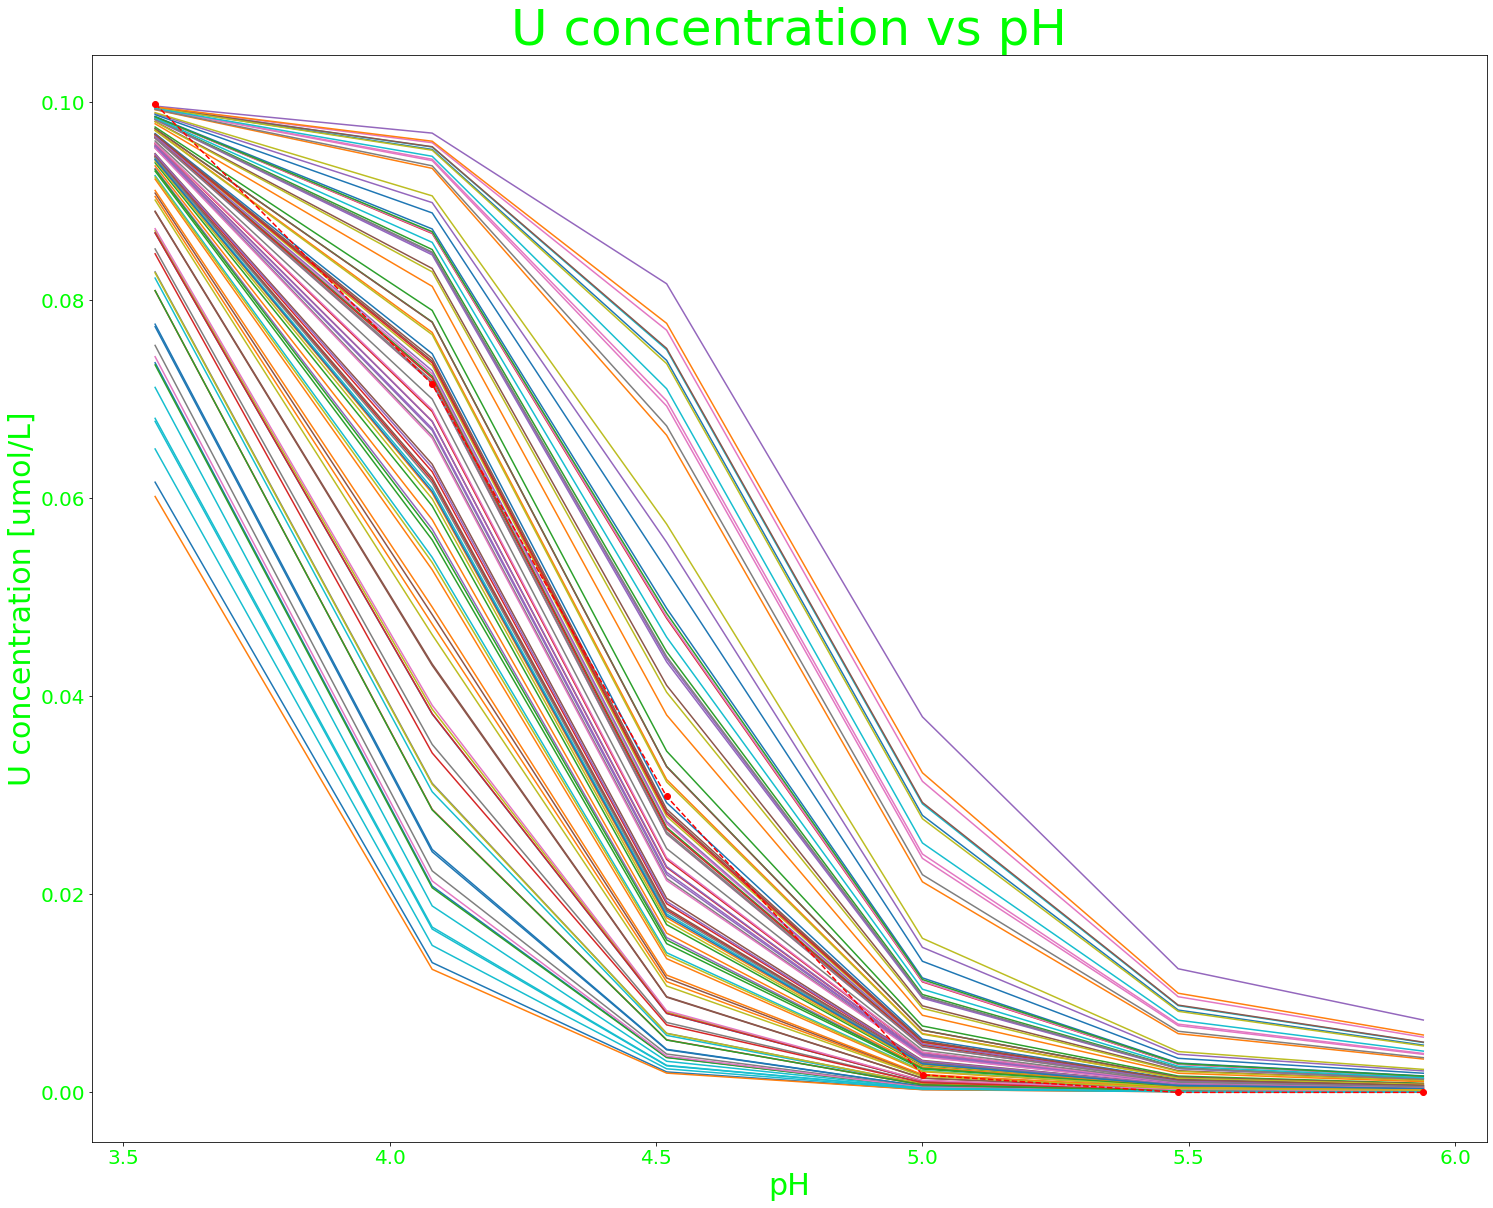

In [7]:
f = plt.figure(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("U concentration vs pH", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('pH', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('U concentration [umol/L]', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

# plotting each result from run_sims
for run in res:
    plt.plot(run[1], run[2]*1e6)

# plotting experimental results for reference
plt.plot(exp_pH, exp_U, 'r--o')

plt.show()

For RSS analysis we can find the residual sum of squares $\Sigma((exp - obs)^2)$ of each run with the experimental U concentration to find the parameters which come closest to the experimental results

In [8]:
# Putting all RSS values in a list to find the minimum index
rss_list = []
for run in res:
    # rss is Sum((expected - observed)^2)
    rss = np.sum(np.square(exp_U - run[2]*1e6))
    rss_list.append(rss)

    
# extracting best analytes from the min index
min_idx = rss_list.index(min(rss_list))
bestconc = res[min_idx][2]
bestanalytes = gen_values[min_idx]

print(rss_list)
print(min(rss_list), min_idx)
print("The best fitting analytes are: {} from run {}.".format(bestanalytes, min_idx))

# write a new .tpl file with the best fit analyte values
writeInput(TDBfile, pars, bestanalytes, TDBfile+"_MCnew")

[0.003357723057177976, 0.0022323596626, 0.00047492413109, 0.0002248983878142002, 0.00042498110854000007, 0.0001993409255689999, 0.00381514564485, 0.00012015604968079983, 3.0147238929599963e-05, 0.002587835781145299, 0.005649901017287299, 0.0058487218606912625, 0.00010963556062839998, 0.0002566010337802002, 0.0004395830230099999, 0.00032006227813000007, 3.100707006760004e-05, 0.0004503873802399995, 0.0017155101683845003, 0.004799061836625079, 0.0017607388717288, 0.0006781247706093003, 0.0003561351917370002, 0.0006558295935, 0.0004611228010272001, 0.00024767584931439994, 0.0006644614612500001, 0.0024860885662538004, 0.0003276192676825001, 0.0005495450764600002, 0.0033934195210474, 0.0010252133762369004, 0.0005155330158052999, 8.842491135169987e-05, 0.0001075302241497001, 0.0009597231887245001, 0.00267271235454, 0.002060672784227, 0.0002935227725399998, 0.0034605843755600007, 0.0032803668588499988, 0.0003048978057652002, 7.84270824048999e-05, 0.0017578430304620001, 0.00010240359542600007,

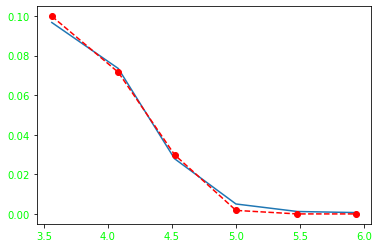

In [9]:
# brief plot of best Monte Carlo run vs the experimental results
plt.xticks(color = 'lime')
plt.yticks(color = 'lime')
plt.plot(res[0][1], bestconc*1e6, exp_pH, exp_U, 'r--o')
plt.show()

#### Optimization

We can use optimization techniques to help determine which parameter values best minimize a cost function. In this case, our cost function is the RSS with the experimental U concentration again.

In [10]:
# first we can use the scipy.optimize.least_squares method to calculate the best fit parameters

import scipy.optimize
import threading

# lock run_sims when calling it to prevent potential multiple readings of the same output file
# before run_sims finishes writing to it
l = threading.RLock()

def locked_run(params, lock):
    lock.acquire()
    res = run_sims([params], opsel)
    lock.release()
    return res[0][2]

def RSS_func(params, lock, prt=False):
    # run phreeqc on params and return the RSS of the results to expected U concentrations
    run = locked_run(params, lock)
    cost = np.sum(np.square(exp_U - run*1e6))
    if prt:
        print(params, run, str(cost)[:9])
    return cost

In [11]:
#scipy.optimize.leastsq(RSS_func, lower)
ls_opt = scipy.optimize.least_squares(RSS_func, np.mean([lower, upper], axis=0), bounds=(lower, upper), diff_step=1.5, args=[l])
ls_opt

 active_mask: array([0, 0, 0, 0])
        cost: 2.9847425948790234e-08
         fun: array([0.00024433])
        grad: array([ 6.98498284e-07, -4.62559792e-07, -2.38400625e-12,  0.00000000e+00])
         jac: array([[ 2.85888643e-03, -1.89321283e-03, -9.75750877e-09,
         0.00000000e+00]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 12
        njev: 1
  optimality: 1.4773238699633828e-06
      status: 3
     success: True
           x: array([ 3.735,  2.535,  9.035, 15.19 ])

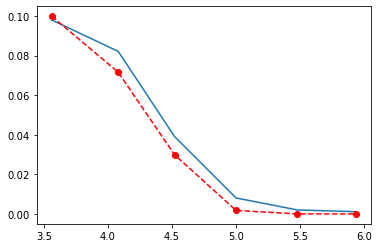

In [12]:
plt.plot(exp_pH, locked_run([ 3.735,  2.535,  9.035, 15.19 ], l)*1e6, exp_pH, exp_U, 'r--o')
plt.show()

In [13]:
# next we can make a mesh grid where we cycle each of the four parameters through a low,
# middle, and upper value...
# except I don't know how to plot a grid with 4 different axes so
# I will use only the first two parameters because the other ones are not too significant
# as shown in the sensitivity analysis portion

# param_vals = np.array((lower, np.mean([lower, upper], axis=0), upper)).T
# mg = np.meshgrid(param_vals[0], param_vals[1], param_vals[2], param_vals[3])
# mesh_input = np.array(mg).T.reshape(81, 4)

# xx, yy = np.meshgrid([1.62, 3.735, 5.85], [1.79, 2.535, 3.28])

xx, yy = np.meshgrid(np.linspace(1.62, 5.85, 50), np.linspace(1.79, 3.28, 50))


# now we build the input array for the grid search
gs_params = [xx[0][0], yy[0][0], lower[2], lower[3]]
for i in range(1, 2500):
    ary = [xx.flatten()[i], yy.flatten()[i], lower[2], lower[3]]
    gs_params = np.vstack((gs_params, ary))

def grid_search(params):
    run = run_sims(params, opsel, ['U'])
    # return with the correct formatting
    res = np.array(run)[:, 1::2].reshape(np.shape(np.array(run))[0], np.shape(np.array(run))[2])
    #calculate cost via RSS
#     cost = np.sum(np.square(exp_U - res[0]*1e6))
#     for row in res[1:]:
#         cost = np.vstack((cost, np.sum(np.square(exp_U - row*1e6))))
#     return cost
    return res

def grid_search_f(params, func):
    # does grid search and applies func as the cost function
    run = run_sims(params, opsel, ['U'])
    # return with the correct formatting
    res = np.array(run)[:, 1::2].reshape(np.shape(np.array(run))[0], np.shape(np.array(run))[2])
    #calculate cost via RSS
    cost = func(res[0]*1e6)
    for row in res[1:]:
        cost = np.vstack((cost, func(row*1e6)))
    return cost

def log_likelihood(concs, conc_measured):
    # applies the log likelihood equation to 1 set of generated concentrations
    # concs: 1 set of concentrations from phreeqc run
#   p = np.power(np.sum(np.array(concs) - conc_measured), 2) / np.std(concs)
#     p = np.power( -1 * np.sum(np.array(concs) - conc_measured), 2) / np.std(concs)
#     p = np.power(np.sum(-1 * np.array(concs) - conc_measured), 2) / np.std(concs)
    concs = concs * 1e6
    p = np.exp(-1 * np.sum(np.power(np.array(concs) - conc_measured, 2)) / np.power(np.std(concs), 2))

#     print("p:", p)
    return p

def ll_func(concs):
    # assume exp_U is defined from cell 1
    return log_likelihood(concs, exp_U)

In [14]:
# gs = grid_search(gs_params)
# np.save("gridsearch_concs.npy",gs)
gsRSS = np.load("gridsearch_8_10.npy")
#     cost = np.sum(np.square(exp_U - res[0]*1e6))
#     for row in res[1:]:
#         cost = np.vstack((cost, np.sum(np.square(exp_U - row*1e6))))

In [15]:
# gs = np.load("gridsearch_concs.npy")
# gsll = np.array(ll_func(gs[0]))
# for i in range(1, len(gs)):
#     gsll = np.vstack((gsll, ll_func(gs[i])))
# np.shape(gsll)


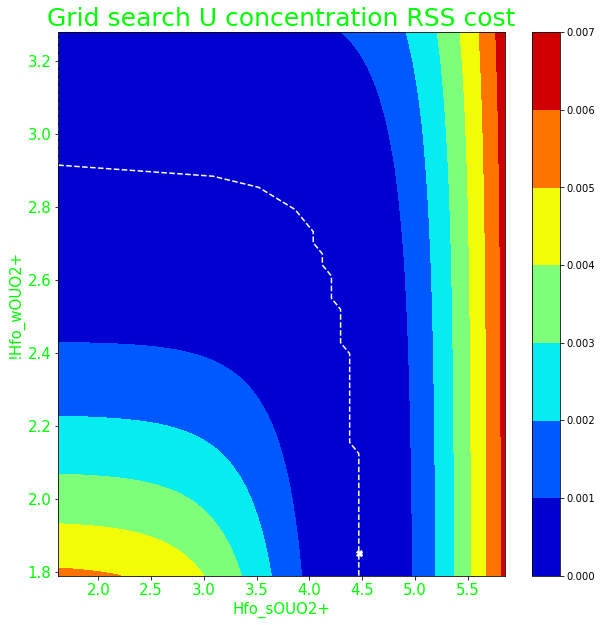

In [16]:
f = plt.figure(figsize=[10,10])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("Grid search U concentration RSS cost", fontdict={'fontsize': 25, 'color': 'lime'})
plt.xlabel('Hfo_sOUO2+', fontdict={'fontsize': 15, 'color': 'lime'})
plt.xticks(fontsize = 15, color = 'lime')
plt.ylabel('!Hfo_wOUO2+', fontdict={'fontsize': 15, 'color': 'lime'})
plt.yticks(fontsize = 15, color = 'lime')


plt.contourf(xx, yy, gsRSS.reshape(50,50), cmap = 'jet')
plt.colorbar()

# finding minimum xx cost value across each row
xx_idx = np.argmin(gsRSS.reshape(50,50), 1)
xx_min = [xx[ii][xx_idx[ii]] for ii in range(len(xx_idx))]

# plotting xx minimum cost parameter for each yy parameter
plt.plot(xx_min, yy[:,0], "w--")
# plt.plot(xx_min[np.argmin(xx_min)], yy[:,0][np.argmin(xx_min)], "rX")

yy_minvals = np.amin(gsRSS.reshape(50,50), 0)
xx_min_idx = np.argmin(yy_minvals)
xx[0,:][xx_min_idx]
xx_minvals = np.amin(gsRSS.reshape(50,50), 1)
yy_min_idx = np.argmin(xx_minvals)
yy[:,0][yy_min_idx]
plt.plot(xx[0,:][xx_min_idx], yy[:,0][yy_min_idx], "wX")


In [17]:
# gsll = grid_search_f(gs_params, ll_func)
# np.save("gs_loglikelihood.npy", gsll)
gsll = np.load("gs_loglikelihood.npy")

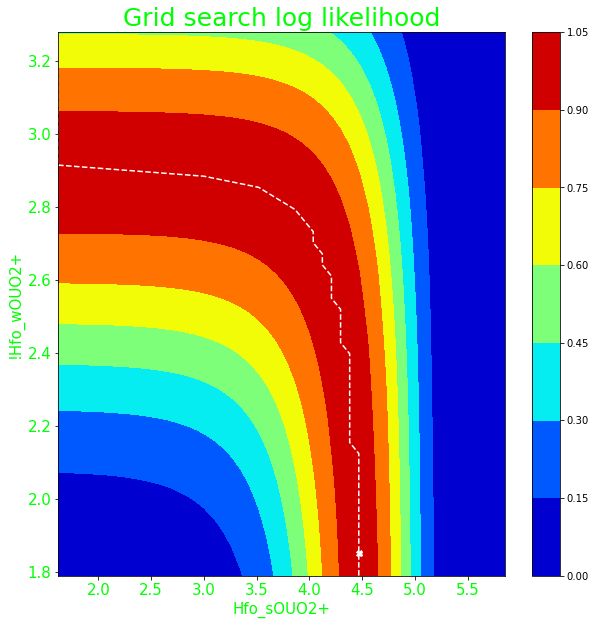

In [18]:
f = plt.figure(figsize=[10,10])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("Grid search log likelihood", fontdict={'fontsize': 25, 'color': 'lime'})
plt.xlabel('Hfo_sOUO2+', fontdict={'fontsize': 15, 'color': 'lime'})
plt.xticks(fontsize = 15, color = 'lime')
plt.ylabel('!Hfo_wOUO2+', fontdict={'fontsize': 15, 'color': 'lime'})
plt.yticks(fontsize = 15, color = 'lime')


plt.contourf(xx, yy, gsll.reshape(50,50), cmap = 'jet')
plt.colorbar()

# finding maximum xx cost value across each column
xx_idx = np.argmax(gsll.reshape(50,50), 1)
xx_max = [xx[ii][xx_idx[ii]] for ii in range(len(xx_idx))]

# plotting xx maximum cost parameter for each yy parameter
plt.plot(xx_max, yy[:,0], "w--")
# plt.plot(xx_max[np.argmax(xx_max)], yy[:,0][np.argmax(xx_max)], "rX")

yy_maxvals = np.amax(gsll.reshape(50,50), 0)
xx_max_idx = np.argmax(yy_maxvals)
xx[0,:][xx_max_idx]
xx_maxvals = np.amax(gsll.reshape(50,50), 1)
yy_max_idx = np.argmax(xx_maxvals)
yy[:,0][yy_max_idx]
plt.plot(xx[0,:][xx_max_idx], yy[:,0][yy_max_idx], "wX")


In [19]:
np.sum(gsll)

1290.7319014648476

In [20]:
yy[:,0][yy_min_idx]

1.8508163265306123

#### Bayesian sampling-resampling method



In [24]:
def bayes_gen_params(lower, upper, pool_size, weights=None, params_set=None):
    """
    ****DEPRECATED****
    this function does not support separation of parameter generation and evaluation
    """
    # generates 1 set of parameters to be used in run_bayes()
    # pool_size: number of samples to choose from within bounds
    # weights: pool_size by "num_parameters" sized weights matrix used for sampling
    # return: 1 list of params
    
    if weights is not None:
        # if we have weights, just return a parameter from the prev-generated params_set 
        # return the ith index as determined by the log_likelihood weights
        return params_set[np.random.choice(np.arange(len(params_set)), p=weights)]
    
    # if no weights, generate parameters randomly one by one
    params = []
    for i in range(len(lower)):
        sample = np.linspace(lower[i], upper[i], num=pool_size)
        params.append(np.random.choice(sample, p=None))
#     print(params)
    return params

def get_norm_weights(concentrations, conc_measured):
    # returns list of normalized weights
#     [print(conc) for conc in concentrations]
    weights = [log_likelihood(concentrations[0], conc_measured)]
    for run in concentrations[1:]:
        weights.append(log_likelihood(run, conc_measured))
        
    norm_weights = np.array(weights) / np.sum(weights)
#     print(norm_weights, np.sum(weights))
    return norm_weights

def run_bayes(num_sims, lower, upper, pool_size=100, resample=1, weights=None, params_set=None):
    """
    ****DEPRECATED****
    not using this function because it does not separate parameter generation and evaluation
    """
    # generate randomized input parameters for phreeqc 'pool_size' times
    params = bayes_gen_params(lower, upper, pool_size, weights, params_set)
    for sim in range(num_sims-1):
        params = np.vstack((params, bayes_gen_params(lower, upper, pool_size,\
                                                     weights, params_set)))
        
    # run phreeqc for matrix of U concentrations
    concs = np.array(run_sims(params, opsel, ['U']))[:, 1::2].reshape((np.shape(params)[0],6))
    
#     print("concs:", concs)
#     print(np.shape(concs))
    # get matrix of new weights
    # assume exp_U is defined from cell 1
    new_weights = get_norm_weights(concs, exp_U)
    
    # wrapping for recursion
    params = [params]
    concs = [concs]
    new_weights = [new_weights]
    
    if resample > 0:
        print("nw: ", new_weights, "\n params: ", params)
        p, c, nw = run_bayes(num_sims, lower, upper, pool_size, resample = resample -1,\
                             weights = new_weights[0], params_set = params[0])
        print("p: ", p)
        params = np.concatenate((params, p))
        concs = np.concatenate((concs, c))
        new_weights = np.concatenate((new_weights, nw))
#         print(params, concs, new_weights)

    return params, concs, new_weights

def _bayes_1params(lower, upper, pool_size=100):
    # helper function for returning 1 set of params
    params = []
    for i in range(len(lower)):
        sample = np.linspace(lower[i], upper[i], num=pool_size)
        params.append(np.random.choice(sample, p=None))
    return params

def bayes_init_params(num_sets, lower, upper, pool_size=100):
    # generates 1 set of parameters to be used in run_bayes()
    # num_sets: number of parameter sets to generate
    # lower, upper: list of parameter bounds
    # pool_size: number of linspace samples to sample from when picking each parameter
    # return: num_sets sets of params as a matrix

    plist = _bayes_1params(lower, upper, pool_size)
    while num_sets > 1:
        plist = np.vstack((plist, _bayes_1params(lower, upper, pool_size)))
        num_sets -= 1
    return plist

def bayes_eval(params):
    # evaluates parameters and returns concentrations, new weights, and parameters given
    
    # run phreeqc for matrix of U concentrations
    concs = np.array(run_sims(params, opsel, ['U']))[:, 1::2].reshape((np.shape(params)[0],6))
    
    # get matrix of new weights
    # assume exp_U from cell 1 is defined
    new_weights = get_norm_weights(concs, exp_U)
    
    return concs, new_weights, params   
    
def bayes_resample(num_trials, num_sets, lower, upper, pool_size=100):
    # samples num_trials times and stacks results
    # remaining input parameters are inputs for bayes_init_params()
    # return: matrix for concs, params, new_weights
    cc, nw, pp = bayes_eval(bayes_init_params(num_sets, lower, upper, pool_size))
    cc = [cc]
    nw = [nw]
    pp = [pp]
    while num_trials > 1:
        # resample parameters with new weights and stack into master list
        re_pp = [pp[-1][np.random.choice(np.arange(len(pp[-1])), p=nw[-1])] for i in range(len(pp[-1]))]
#         print(pp, re_pp)
        pp = np.vstack((pp, [re_pp]))
        
        # evaluate and stack other values
        re_cc, re_nw, _ = bayes_eval(pp[-1])
        cc = np.vstack((cc, [re_cc]))
        nw = np.vstack((nw, [re_nw]))
        num_trials -= 1
    return cc, nw, pp

def bayes_param_count_(pp_mtrx):
    # returns list of summed counts of each original parameter
        
    params_count = np.ones(len(pp_mtrx[0]))
    # summing while accounting for the shape of input
    if len(np.shape(pp_mtrx)) > 2:
        for i in range(1, len(pp_mtrx)):
            for p in pp_mtrx[i]:
                params_count[pp_mtrx[0].tolist().index(list(p))] += 1
    else:
        for i in range(1, len(pp_mtrx)):
            for p in pp_mtrx[i]:
                params_count[pp_mtrx[0].tolist().index(p)] += 1
    return params_count

def bayes_param_count(pp_mtrx, original_params):
    # can be implemented additively
    # returns list of summed counts of each original parameter
        
    params_count = np.zeros(len(original_params))
    # summing while accounting for the shape of input
    if len(np.shape(pp_mtrx)) > 2:
        for i in range(len(pp_mtrx)):
            for p in pp_mtrx[i]:
                params_count[original_params.tolist().index(list(p))] += 1
    else:
        for i in range(len(pp_mtrx)):
            for p in pp_mtrx[i]:
                params_count[original_params.tolist().index(p)] += 1
    return params_count


In [22]:
# cc, nw, pp = bayes_resample(100, 50, lower, upper, 100)
# np.savez("bayes_resp_8_25.npz", cc=cc, nw=nw, pp=pp)
resp_100 =  np.load("bayes_resp_8_25.npz")

In [25]:
# plotting 2D heatmap of counts per strong and weak UO2 parameter value

import pandas as pd
import plotly.express as px

# setting up plot values
pp = resp_100['pp']
# counting number of hits 
param_count = bayes_param_count_(pp)
df = pd.DataFrame({'Hfo_sOUO2+' : pp[0].T[0], 'Hfo_wOUO2+' : pp[0].T[1], 'count' : param_count})

px.density_heatmap(df, x="Hfo_sOUO2+", y="Hfo_wOUO2+", z="count", \
                   marginal_x="histogram", marginal_y="histogram")

In [26]:
len(np.shape(pp))

3

In [27]:
px.density_heatmap(df, x="Hfo_sOUO2+", y="Hfo_wOUO2+", z="count", nbinsx=50, nbinsy=50, \
                   marginal_x="histogram", marginal_y="histogram")

In [28]:
def gs_resample(num_trials):
    # samples num_trials times from gs_log_likelihood grid and stacks results
    # return: num_trials by 2500 matrix of each index sampled from gsll grid

    # summing the indices of the grid search
    pp = [np.arange(len(gsll))]
    
    while num_trials > 1:
        # resample parameters with new weights and stack into master list
        samples = gsll[[np.arange(len(gsll))][-1]]
        samples = samples / np.sum(samples)
        re_pp = [pp[-1][np.random.choice(pp[-1], p=samples.T[0])] for i in range(len(pp[-1]))]
        pp = np.vstack((pp, re_pp))
#         print(np.shape(pp))
        num_trials -= 1
    return pp

In [29]:
# gsr = gs_resample(500)
# np.save("gsr.npy", gsr)
gsr = np.load("gsr.npy")

In [30]:
# gsll = np.load("gs_loglikelihood.npy")
# gsr200 = gs_resample(200)
# np.save("gsr200.npy", gsr200)
# gsr200 = np.load("gsr200.npy")


In [31]:
# # gsll = np.load("gs_loglikelihood.npy")
# # gsr400 = gs_resample(400)
# # np.save("gsr400.npy", gsr400)
# # # gsr400 = np.load("gsr400.npy")

# gspc400 = bayes_param_count(gsr400)
# np.save("gspc400.npy", gspc400)
gspc400 = np.load("gspc400.npy")

In [32]:
gsll = np.load("gs_loglikelihood.npy")
# gsr600 = gs_resample(600)
# np.save("gsr600.npy", gsr600)
gsr600 = np.load("gsr600.npy")

# gspc600 = bayes_param_count(gsr600)
# np.save("gspc600.npy", gspc600)
gspc600 = np.load("gspc600.npy")

In [33]:
# np.random.seed(3)
# gsll = np.load("gs_loglikelihood.npy")
# gsr200 = gs_resample(200)
# gspc200 = bayes_param_count(gsr200)
# # np.save("gspc200.npy", gspc200)
gspc200 = np.load("gspc200.npy")

In [34]:
# gs_param_count = bayes_param_count(gsr)
# np.save("gspc.npy", gs_param_count)
gs_param_count = np.load("gspc.npy")

The best values are: 3.260204081632653 2.8238775510204084


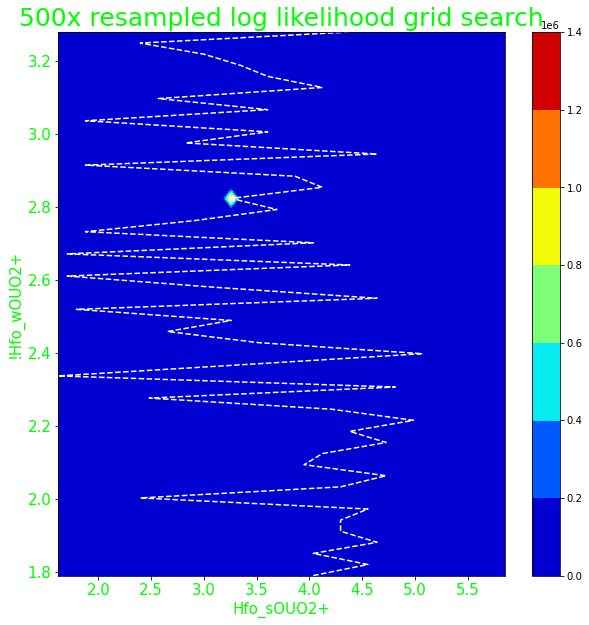

In [35]:
f = plt.figure(figsize=[10,10])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("500x resampled log likelihood grid search", fontdict={'fontsize': 25, 'color': 'lime'})
plt.xlabel('Hfo_sOUO2+', fontdict={'fontsize': 15, 'color': 'lime'})
plt.xticks(fontsize = 15, color = 'lime')
plt.ylabel('!Hfo_wOUO2+', fontdict={'fontsize': 15, 'color': 'lime'})
plt.yticks(fontsize = 15, color = 'lime')


plt.contourf(xx, yy, gs_param_count.reshape(50,50), cmap = 'jet')
plt.colorbar()

# finding maximum xx cost value across each column
xx_idx = np.argmax(gs_param_count.reshape(50,50), 1)
xx_max = [xx[ii][xx_idx[ii]] for ii in range(len(xx_idx))]

# plotting xx maximum cost parameter for each yy parameter
plt.plot(xx_max, yy[:,0], "w--")
# plt.plot(xx_max[np.argmax(xx_max)], yy[:,0][np.argmax(xx_max)], "rX")

yy_maxvals = np.amax(gs_param_count.reshape(50,50), 0)
xx_max_idx = np.argmax(yy_maxvals)
xx[0,:][xx_max_idx]
xx_maxvals = np.amax(gs_param_count.reshape(50,50), 1)
yy_max_idx = np.argmax(xx_maxvals)
yy[:,0][yy_max_idx]
plt.plot(xx[0,:][xx_max_idx], yy[:,0][yy_max_idx], "wX")
print("The best values are:", xx[0,:][xx_max_idx], yy[:,0][yy_max_idx])

The best values are: 4.900408163265306 2.246122448979592


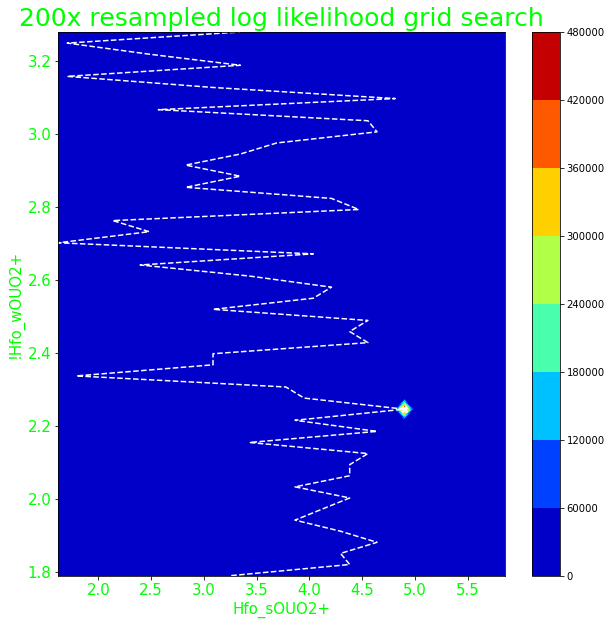

In [36]:
f = plt.figure(figsize=[10,10])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("200x resampled log likelihood grid search", fontdict={'fontsize': 25, 'color': 'lime'})
plt.xlabel('Hfo_sOUO2+', fontdict={'fontsize': 15, 'color': 'lime'})
plt.xticks(fontsize = 15, color = 'lime')
plt.ylabel('!Hfo_wOUO2+', fontdict={'fontsize': 15, 'color': 'lime'})
plt.yticks(fontsize = 15, color = 'lime')


plt.contourf(xx, yy, gspc200.reshape(50,50), cmap = 'jet')
plt.colorbar()

# finding maximum xx cost value across each column
xx_idx = np.argmax(gspc200.reshape(50,50), 1)
xx_max = [xx[ii][xx_idx[ii]] for ii in range(len(xx_idx))]

# plotting xx maximum cost parameter for each yy parameter
plt.plot(xx_max, yy[:,0], "w--")
# plt.plot(xx_max[np.argmax(xx_max)], yy[:,0][np.argmax(xx_max)], "rX")

yy_maxvals = np.amax(gspc200.reshape(50,50), 0)
xx_max_idx = np.argmax(yy_maxvals)
xx[0,:][xx_max_idx]
xx_maxvals = np.amax(gspc200.reshape(50,50), 1)
yy_max_idx = np.argmax(xx_maxvals)
yy[:,0][yy_max_idx]
plt.plot(xx[0,:][xx_max_idx], yy[:,0][yy_max_idx], "wX")
print("The best values are:", xx[0,:][xx_max_idx], yy[:,0][yy_max_idx])

The best values are: 4.382448979591837 2.8238775510204084


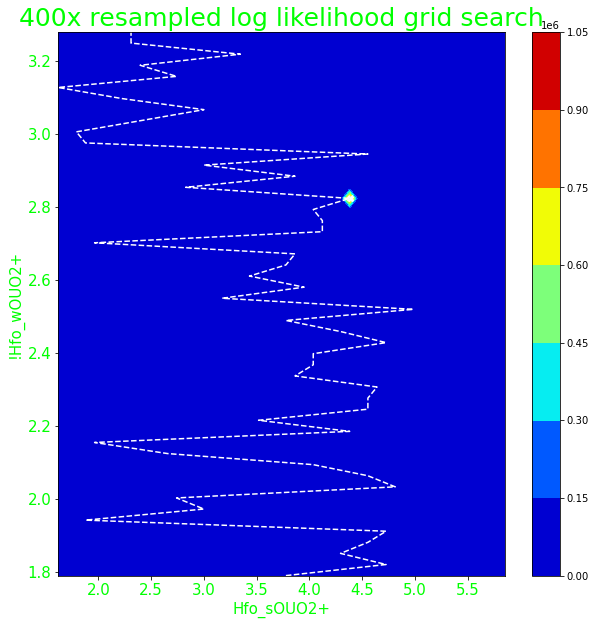

In [37]:
f = plt.figure(figsize=[10,10])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("400x resampled log likelihood grid search", fontdict={'fontsize': 25, 'color': 'lime'})
plt.xlabel('Hfo_sOUO2+', fontdict={'fontsize': 15, 'color': 'lime'})
plt.xticks(fontsize = 15, color = 'lime')
plt.ylabel('!Hfo_wOUO2+', fontdict={'fontsize': 15, 'color': 'lime'})
plt.yticks(fontsize = 15, color = 'lime')


plt.contourf(xx, yy, gspc400.reshape(50,50), cmap = 'jet')
plt.colorbar()

# finding maximum xx cost value across each column
xx_idx = np.argmax(gspc400.reshape(50,50), 1)
xx_max = [xx[ii][xx_idx[ii]] for ii in range(len(xx_idx))]

# plotting xx maximum cost parameter for each yy parameter
plt.plot(xx_max, yy[:,0], "w--")
# plt.plot(xx_max[np.argmax(xx_max)], yy[:,0][np.argmax(xx_max)], "rX")

yy_maxvals = np.amax(gspc400.reshape(50,50), 0)
xx_max_idx = np.argmax(yy_maxvals)
xx[0,:][xx_max_idx]
xx_maxvals = np.amax(gspc400.reshape(50,50), 1)
yy_max_idx = np.argmax(xx_maxvals)
yy[:,0][yy_max_idx]
plt.plot(xx[0,:][xx_max_idx], yy[:,0][yy_max_idx], "wX")
print("The best values are:", xx[0,:][xx_max_idx], yy[:,0][yy_max_idx])

The best values are: 4.555102040816326 2.7326530612244895


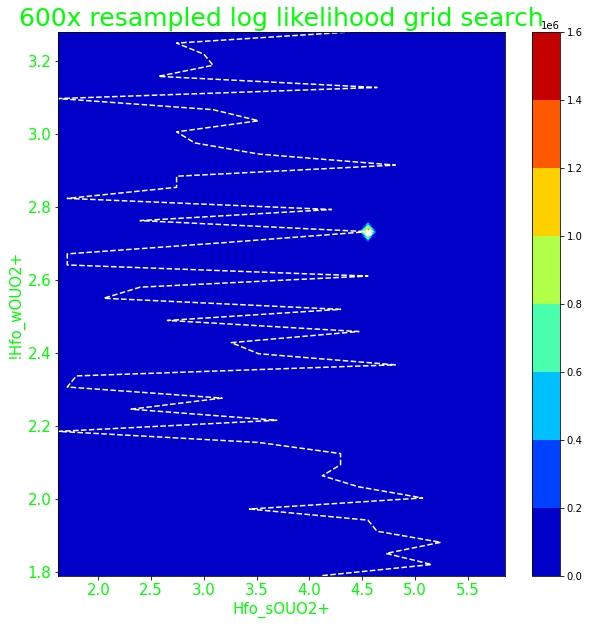

In [38]:
f = plt.figure(figsize=[10,10])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("600x resampled log likelihood grid search", fontdict={'fontsize': 25, 'color': 'lime'})
plt.xlabel('Hfo_sOUO2+', fontdict={'fontsize': 15, 'color': 'lime'})
plt.xticks(fontsize = 15, color = 'lime')
plt.ylabel('Hfo_wOUO2+', fontdict={'fontsize': 15, 'color': 'lime'})
plt.yticks(fontsize = 15, color = 'lime')


plt.contourf(xx, yy, gspc600.reshape(50,50), cmap = 'jet')
plt.colorbar()

# finding maximum xx cost value across each column
xx_idx = np.argmax(gspc600.reshape(50,50), 1)
xx_max = [xx[ii][xx_idx[ii]] for ii in range(len(xx_idx))]

# plotting xx maximum cost parameter for each yy parameter
plt.plot(xx_max, yy[:,0], "w--")
# plt.plot(xx_max[np.argmax(xx_max)], yy[:,0][np.argmax(xx_max)], "rX")

yy_maxvals = np.amax(gspc600.reshape(50,50), 0)
xx_max_idx = np.argmax(yy_maxvals)
xx[0,:][xx_max_idx]
xx_maxvals = np.amax(gspc600.reshape(50,50), 1)
yy_max_idx = np.argmax(xx_maxvals)
yy[:,0][yy_max_idx]
plt.plot(xx[0,:][xx_max_idx], yy[:,0][yy_max_idx], "wX")
print("The best values are:", xx[0,:][xx_max_idx], yy[:,0][yy_max_idx])

In [39]:
np.shape(gsr600)

(600, 2500)

In [42]:
def best_params_by_num_samples(resamp_gs, step_size):
    steps = range(step_size, len(resamp_gs[0])+1, step_size)
    prev_s = 0
    gspc = np.zeros(len(resamp_gs[0]))
    samples_dict = dict()
    for s in steps:
        gspc = gspc + bayes_param_count(resamp_gs[prev_s:s], resamp_gs[0])
#         print(gspc)
        yy_maxvals = np.amax(gspc.reshape(50,50), 0)
        xx_max_idx = np.argmax(yy_maxvals)
        xx_maxvals = np.amax(gspc.reshape(50,50), 1)
        yy_max_idx = np.argmax(xx_maxvals)
        prev_s = s
        samples_dict[s] = (xx[0,:][xx_max_idx], yy[:,0][yy_max_idx])
    return samples_dict

def consecutive_resample(max_samples, step_size):
    steps = range(step_size, max_samples + 1, step_size)
    samples_dict = dict()

    for s in steps:
        gspc = bayes_param_count_(gs_resample(s))
        yy_maxvals = np.amax(gspc.reshape(50,50), 0)
        xx_max_idx = np.argmax(yy_maxvals)
        xx_maxvals = np.amax(gspc.reshape(50,50), 1)
        yy_max_idx = np.argmax(xx_maxvals)
        samples_dict[s] = (xx[0,:][xx_max_idx], yy[:,0][yy_max_idx])
    return samples_dict

In [43]:
gsll = np.load("gs_loglikelihood.npy")
csr = consecutive_resample(200, 10)
csr

{10: (1.62, 2.4285714285714284),
 20: (3.5191836734693878, 2.7022448979591838),
 30: (2.0516326530612243, 2.6414285714285715),
 40: (4.986734693877551, 2.7326530612244895),
 50: (2.8285714285714283, 2.2157142857142857),
 60: (1.62, 2.4893877551020407),
 70: (2.0516326530612243, 2.063673469387755),
 80: (4.555102040816326, 2.3677551020408165),
 90: (4.037142857142857, 3.0975510204081633),
 100: (1.706326530612245, 2.7326530612244895),
 110: (4.6414285714285715, 2.2157142857142857),
 120: (2.0516326530612243, 3.127959183673469),
 130: (4.727755102040817, 3.1887755102040813),
 140: (2.1379591836734697, 2.4893877551020407),
 150: (3.5191836734693878, 2.033265306122449),
 160: (4.382448979591837, 3.0671428571428567),
 170: (2.9148979591836737, 2.793469387755102),
 180: (3.7781632653061226, 2.6414285714285715),
 190: (4.382448979591837, 2.2157142857142857),
 200: (3.950816326530612, 1.8812244897959185)}

20

[]

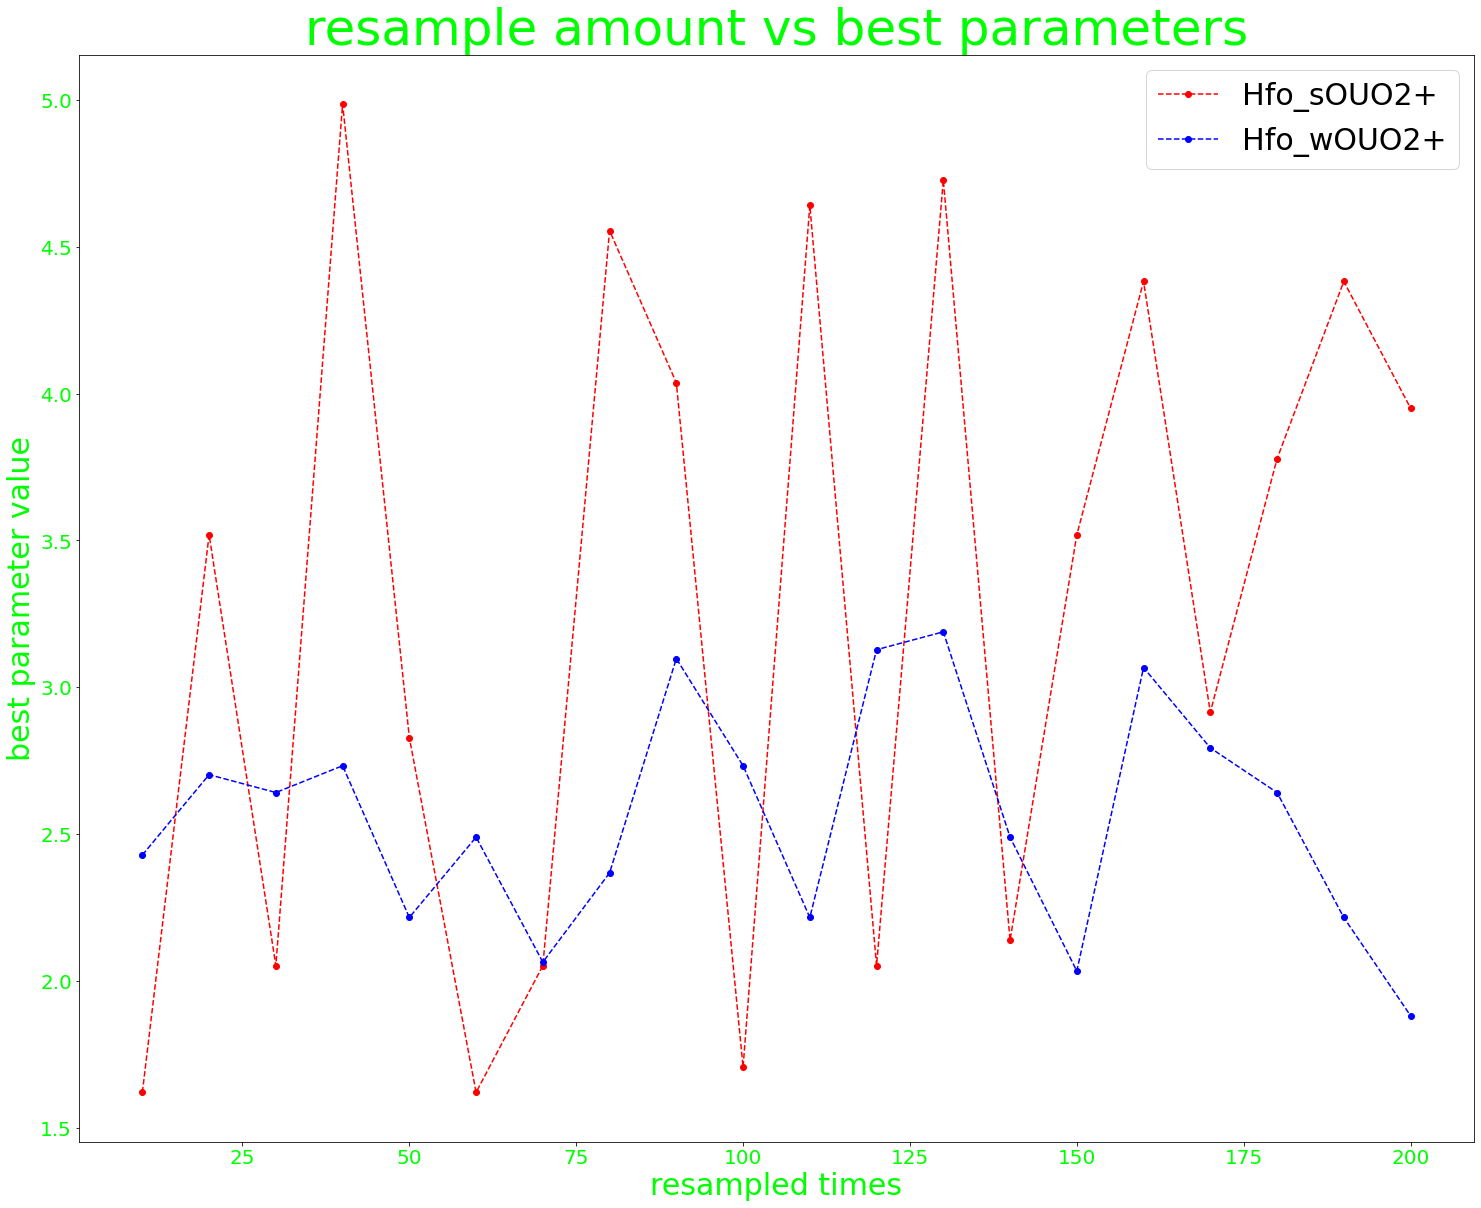

In [60]:
f, ax = plt.subplots(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("resample amount vs best parameters", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('resampled times', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('best parameter value', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

ax.plot(list(csr.keys()), [tup[0] for tup in csr.values()], "ro--", label="Hfo_sOUO2+")
ax.plot(list(csr.keys()), [tup[1] for tup in csr.values()], "bo--", label="Hfo_wOUO2+")

ax.legend(fontsize=30)
ax.plot()

In [71]:
params_by_samples = best_params_by_num_samples(gsr600, step_size=10)

[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1.

In [74]:
params_by_samples

{10: (1.706326530612245, 2.3981632653061222),
 20: (4.296122448979592, 2.580612244897959),
 30: (4.296122448979592, 2.580612244897959),
 40: (4.296122448979592, 2.580612244897959),
 50: (4.296122448979592, 2.580612244897959),
 60: (4.296122448979592, 2.580612244897959),
 70: (4.296122448979592, 2.580612244897959),
 80: (4.296122448979592, 2.580612244897959),
 90: (4.296122448979592, 2.580612244897959),
 100: (4.296122448979592, 2.580612244897959),
 110: (4.296122448979592, 2.580612244897959),
 120: (4.296122448979592, 2.580612244897959),
 130: (4.296122448979592, 2.580612244897959),
 140: (4.296122448979592, 2.580612244897959),
 150: (4.296122448979592, 2.580612244897959),
 160: (4.296122448979592, 2.580612244897959),
 170: (4.296122448979592, 2.580612244897959),
 180: (4.296122448979592, 2.580612244897959),
 190: (4.296122448979592, 2.580612244897959),
 200: (4.296122448979592, 2.580612244897959),
 210: (4.296122448979592, 2.580612244897959),
 220: (4.296122448979592, 2.58061224489795

In [76]:
[print(r) for r in gsr600[:20]]

[   0    1    2 ... 2497 2498 2499]
[2209 2401  409 ... 2123  976  287]
[2426 1534 1429 ... 1906  726 2368]
[1979 2160 1576 ... 1958 2036 1689]
[1365 2139 1437 ...  901  910 2176]
[ 937 1425 1525 ... 2419 1327 1711]
[1562  430  386 ... 2055 1294  430]
[2055 1805 1001 ... 1557  386 1805]
[1557  676 1331 ...  386  676 1001]
[ 386  386 1001 ... 1553 1001  386]
[1001 1331 1331 ... 1331 1331 1001]
[1001 1331 1331 ... 1001 1001 1001]
[1331 1331 1331 ... 1331 1331 1331]
[1331 1331 1331 ... 1331 1331 1331]
[1331 1331 1331 ... 1331 1331 1331]
[1331 1331 1331 ... 1331 1331 1331]
[1331 1331 1331 ... 1331 1331 1331]
[1331 1331 1331 ... 1331 1331 1331]
[1331 1331 1331 ... 1331 1331 1331]
[1331 1331 1331 ... 1331 1331 1331]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

#### Sensitivity Analysis

We will use the morris analysis functions from the Sensitivity Analysis Library package to find which of the four initial parameters are the most significant

---
large mean (mu) = large response to perturbation

large sigma = elementary effects depend highly on choice of sample point (response is non-linear)

small sigma = EEs similar for different selected sample points; effect of parameter independent of other parameter values

In [ ]:
from SALib.sample import morris as ssm
from SALib.analyze import morris as sam

# Define the model inputs
problem = {
    'num_vars': 4,
    'names': ['!Hfo_sOUO2+!', '!Hfo_wOUO2+!', '!Hfo_wOUO2CO3-!', '!Hfo_wOUO2(CO3)2-3!'],
    'bounds': [[1.62, 5.85], [1.79, 3.28], [8.75, 9.32], [15.2, 15.28]]
}


# runs run_sims and formats analyte results into matrix of iteration# and observation
# save matrix results into file
# write function to load file later
def ensemble_sim(params, opsel, analyte=['U'], savefile=''):
    # analyte: single analyte to measure; name of colummn from phreeqc .sel output file
    # savefile: saves results array to a .npy file. needs to contain '.npy' in name
    #    also saves params array as 'savefile_p.npy'
    # return: #simulations by #observations matrix

    sims = run_sims(params, opsel, analyte)
    
    # [0][1] index of run_sims will be the list of analyte values 
    output = sims[0][1]
    for sim in sims[1:]:
        output = np.vstack((output, sim[1]))
    
    if savefile:
        if ".npy" in savefile:
            np.save(savefile, output)
            sfp = savefile.split(".npy")[0]+"_p.npy"
            np.save(sfp, params)
        else:
            print("error: savefile name \"{}\" does not contain '.npy': Results not saved."\
                  .format(savefile))
    
    return output

def load_sim(savefile):
    if ".npy" not in savefile:
        print("error: file name \"{}\" does not contain '.npy'".format(savefile))
        return
    return np.load(savefile)

# generates a list of morris result dictionaries per parameter
def morris_analysis(X, Y):
    # Perform Morris analysis on first parameter
    morris_result = [sam.analyze(problem, X, Y.T[0], conf_level=0.95, num_levels=4,
                         print_to_console=False)]

    # Storing the sensitivity indices as a list of dictionaries
    # each dictionary represents the results for one observation
    for i_obs in range(1, np.shape(Y)[1]):
        Si = sam.analyze(problem, X, Y.T[i_obs], conf_level=0.95, num_levels=4, 
                         print_to_console=False)
        morris_result.append(Si)

#     # Making a matrix of observations by parameters
#     mu_all = morris_result[0].get("mu")
#     for obs in morris_result[1:]:
#         mu_all = np.vstack((mu_all, obs.get("mu")))
        
    return morris_result


def dicts_to_mtrx(dlist, key):
    # helper function to convert SALib dictionary results back into matrices
    mtrx = dlist[0].get(key)
    for d in dlist[1:]:
        mtrx = np.vstack((mtrx, d.get(key)))
    return mtrx

def morris_summary(morris_res):
    # returns SALib dictionary results in matrix form by (parameter, simulation#)
    return dicts_to_mtrx(morris_res, "mu").T, dicts_to_mtrx(morris_res, "mu_star").T, \
        dicts_to_mtrx(morris_res, "sigma").T, dicts_to_mtrx(morris_res, "mu_star_conf").T

In [ ]:
import numpy as np
Y = np.load("7_19sim.npy")
np.shape(Y)

In [ ]:
# Generate samples according to the morris method
# in this case it's 20*(num_vars+1) sets of 4 parameters within the bounds
num_traj = 20
# X = ssm.morris.sample(problem, num_traj)
X = load_sim("7_19sim_p.npy")

# Calculate model outputs
# Y = ensemble_sim(X, opsel, savefile="7_19sim.npy")
Y = load_sim("7_19sim.npy")

# generate results
morris_res = morris_analysis(X, Y)
morris_res

In [ ]:
ms = morris_summary(morris_res)
ms

In [ ]:
f, ax = plt.subplots(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("morris mean abs EE vs pH", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('pH', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('mean |EE|', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

for i in range(len(ms[1])):
    ax.plot(exp_pH, ms[1][i], marker='o', label="{}".format(pars[i]))
    ax.plot(exp_pH, ms[1][i]-ms[3][i]/2, ls='--', color=ax.lines[-1].get_color())
    ax.plot(exp_pH, ms[1][i]+ms[3][i]/2, ls='--', color=ax.lines[-2].get_color())

ax.legend(fontsize=30)
ax.plot()

In [ ]:
f, ax = plt.subplots(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("morris std EE vs mean EE", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('mean EE', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('std EE', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

for i in range(len(ms[1])):
    plt.plot(ms[0][i], ms[2][i], marker='o', label="{}".format(pars[i]))
plt.legend(fontsize=30)

# plotting mean EE = +/- 2SEM line
# where SEM = std/sqrt(num_traj)
# note how in the corner of the graph the order of magnitude for mean EE is 1e-8
mean_range = np.arange(0, 7e-8, 0.1e-8)
plt.plot(mean_range, mean_range * np.sqrt(num_traj) / 2, 'k-')
plt.plot(mean_range * -1, mean_range * np.sqrt(num_traj) / 2, 'k-')
plt.vlines(0, 0, 1.6e-7, ls='--')
plt.show()

from a youtube video https://www.youtube.com/watch?v=P8Rfipkid3w:

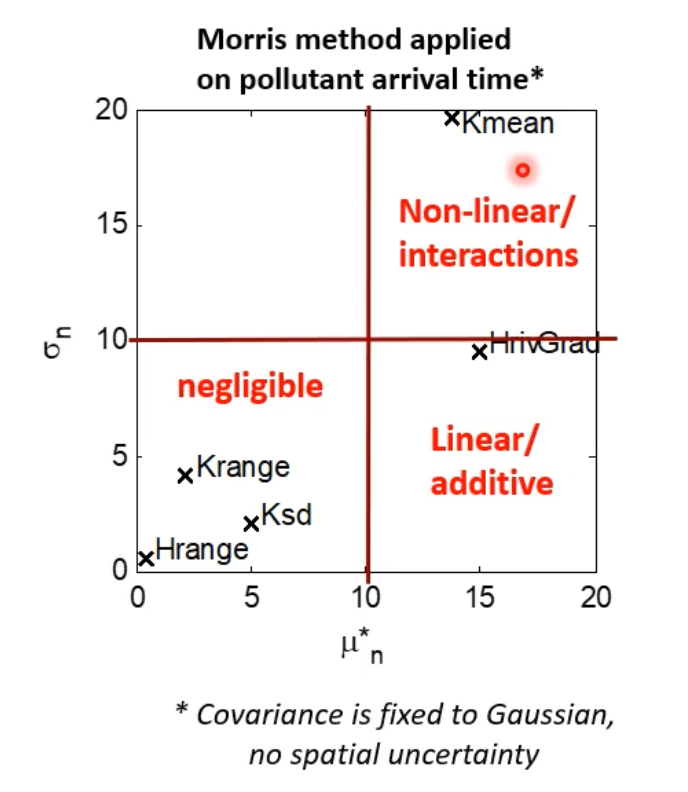

Now we will use the sobol method from the same library

In [ ]:
from SALib.sample import saltelli as sss
from SALib.analyze import sobol as sas

def sobol_analysis(X, Y):
    # Perform sobol analysis on parameter 1
    sobol_result = [sas.analyze(problem, Y.T[0], conf_level=0.95, print_to_console=False)]

    # Storing the sensitivity indices as a list of dictionaries
    # each dictionary represents the results for one observation
    # returning this list instead gets a lot more information, but it might not
    # be necessary for now
    for i_obs in range(1, np.shape(Y)[1]):
        Si = sas.analyze(problem, Y.T[i_obs], conf_level=0.95, print_to_console=False)
        sobol_result.append(Si)
        
    return sobol_result

In [ ]:
sob_traj = 256
X = sss.sample(problem, sob_traj)
X = load_sim("7_22sim_p.npy")
# Y = ensemble_sim(X, opsel, savefile="7_22sim.npy")
Y = load_sim("7_22sim.npy")
sr = sobol_analysis(X, Y)


In [ ]:
sb_s1 = dicts_to_mtrx(sr, "S1").T
sb_s1c = dicts_to_mtrx(sr, "S1_conf").T
f, ax = plt.subplots(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("sobol S1 value vs pH", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('pH', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('S1', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

for i in range(len(sb_s1)):
    ax.plot(exp_pH, sb_s1[i], marker='o', label="{}".format(pars[i]))
    ax.plot(exp_pH, sb_s1[i]-sb_s1c[i]/2, ls='--', color=ax.lines[-1].get_color())
    ax.plot(exp_pH, sb_s1[i]+sb_s1c[i]/2, ls='--', color=ax.lines[-2].get_color())
ax.legend(fontsize=30)
ax.plot()

In [ ]:
sb_st = dicts_to_mtrx(sr, "ST").T
sb_stc = dicts_to_mtrx(sr, "ST_conf").T
f, ax = plt.subplots(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("sobol ST value vs pH", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('pH', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('ST', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

for i in range(len(sb_st)):
    ax.plot(exp_pH, sb_st[i], marker='o', label="{}".format(pars[i]))
    ax.plot(exp_pH, sb_st[i]-sb_stc[i]/2, ls='--', color=ax.lines[-1].get_color())
    ax.plot(exp_pH, sb_st[i]+sb_stc[i]/2, ls='--', color=ax.lines[-2].get_color())
ax.legend(fontsize=30)
ax.plot()